In [22]:
import matplotlib as plt 
import pickle
import shap
import lightgbm as lgb
import pandas as pd
from settings import *
from Functions.LGBModel import generate_study, generate_oos_pred
from Functions.Utils import log_message, newey_west_adj
from Scripts.NNTraining import attach_training_dev_util
import seaborn as sns
import numpy as np
import os

In [38]:
#new visualization functions
def plot_lgbm_feature_importance_map(model, feature_names, name, model_name, cmap='RdBu_r', figsize=(12, 8), top_n=30):
    importance_gain = model.feature_importances_
    importance_split = model.booster_.feature_importance(importance_type='split')

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'gain': importance_gain,
        'split': importance_split
    })

    importance_df = importance_df.sort_values('gain', ascending=False).head(top_n)
    
    heatmap_data = importance_df[['gain', 'split']].T
    heatmap_data.columns = importance_df['feature']
    
    heatmap_data_norm = heatmap_data.div(heatmap_data.max(axis=1), axis=0)
    
    plt.figure(figsize=figsize)
    ax = sns.heatmap(heatmap_data_norm, 
                     annot=False, 
                     cmap=cmap, 
                     center=0.5, 
                     linewidths=0.4,
                     cbar_kws={'label': 'Normalized Importance'})
    
    ax.set_title(f'Feature Importance Heatmap - {model_name}', fontsize=14, pad=20)
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Importance Type', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    save_path = './' 
    plt.savefig(os.path.join(save_path, f'featureimportance_{name}_{model_name}.pdf'), 
                bbox_inches='tight', dpi=300)
    plt.show()
    
    return importance_df
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

def get_bins(df, x, winsorize=True, i=100):
    """
    Bin data for smoother plotting (from original code)
    """
    x_lower, x_upper = np.percentile(df[x], [5, 95])
    df = df[(df[x] >= x_lower) & (df[x] <= x_upper)].copy()
    
    df.sort_values(by=x, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['bin'] = df.index // i
    return df

def weighted_means(df, group, y, x, w):
    """
    Calculate weighted means for plotting (from original code)
    """
    df[w] = df[w] / df.groupby(group)[w].transform('sum')
    df[y] = df[y] * df[w]
    df[x] = df[x] * df[w]
    return df.groupby(group)[[x, y]].sum().reset_index(drop=True)

def plot_shap_partial_dependence(shap_values, X_test, feature_names, 
                                continuous_variables=None, 
                                continuous_variable_names=None,
                                categories=None, category_names=None,
                                figsize=(12, 10), save_path=None):
    
    if continuous_variables is None:
        continuous_variables = X_test.select_dtypes(include=[np.number]).columns.tolist()[:9]
    
    if continuous_variable_names is None:
        continuous_variable_names = continuous_variables
    
    if categories is None:
        categories = ['Model']
        shap_values = [shap_values]
    
    if category_names is None:
        category_names = categories
    
    n_vars = len(continuous_variables)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1:
        ax = ax.reshape(1, -1)
    ax = ax.flatten()
    
    for j, var in enumerate(continuous_variables):
        if j >= len(ax):
            break
            
        var_idx = feature_names.index(var) if var in feature_names else None
        if var_idx is None:
            continue
            
        for i, (cat, shap_vals) in enumerate(zip(categories, shap_values)):
            if hasattr(shap_vals, 'values'):
                shap_array = shap_vals.values
                base_values = shap_vals.base_values
            else:
                shap_array = shap_vals
                base_values = 0
                
            plot_df = pd.DataFrame({
                'X': X_test[var].values,
                'shap': shap_array[:, var_idx] + (base_values if np.isscalar(base_values) else base_values.mean())
            })
            
            plot_df = get_bins(plot_df.copy(), 'X', winsorize=True, i=100)
            plot_df = plot_df.groupby('bin').agg(X=('X', 'mean'), shap=('shap', 'mean')).reset_index()
            plot_df = plot_df.groupby('X')['shap'].mean().reset_index()
            
            ax[j].scatter(plot_df['X'], plot_df['shap'], 
                         label=cat, color=color_list[i], 
                         s=3, alpha=0.8)

            if len(plot_df) > 5:
                z = np.polyfit(plot_df['X'], plot_df['shap'], 
                              min(4, len(plot_df)-1))
                p = np.poly1d(z)
                ax[j].plot(plot_df['X'], p(plot_df['X']), 
                          color=color_list[i], linewidth=1.5)
            
        ax[j].set_title(continuous_variable_names[j])
        ax[j].set_xlabel(var)
        ax[j].set_ylabel('SHAP Value')
        
        if j == 0:
            ax[j].legend()
    # Hide unused subplots
    for j in range(len(continuous_variables), len(ax)):
        ax[j].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches='tight')
    
    plt.show()
    return fig

def plot_shap_interactions(shap_interaction_values, X_test, feature_names,
                          main_feature, interaction_features,
                          categories=None, category_names=None,
                          figsize=(15, 10), save_path=None):
    
    main_idx = feature_names.index(main_feature)
    
    n_interactions = len(interaction_features)
    n_cols = min(3, n_interactions)
    n_rows = (n_interactions + n_cols - 1) // n_cols
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1:
        ax = ax.reshape(1, -1)
    ax = ax.flatten()
    
    for i, interact_feature in enumerate(interaction_features):
        if i >= len(ax):
            break
            
        interact_idx = feature_names.index(interact_feature)
        
        interaction_effect = shap_interaction_values[:, main_idx, interact_idx]
        
        plot_df = pd.DataFrame({
            'main_feature': X_test[main_feature].values,
            'interact_feature': X_test[interact_feature].values,
            'interaction': interaction_effect
        })
        
        plot_df['main_bins'] = pd.qcut(plot_df['main_feature'], q=20, labels=False, duplicates='drop')
        plot_df['interact_bins'] = pd.qcut(plot_df['interact_feature'], q=20, labels=False, duplicates='drop')
        
        agg_data = plot_df.groupby(['main_bins', 'interact_bins']).agg({
            'main_feature': 'mean',
            'interact_feature': 'mean', 
            'interaction': 'mean'
        }).reset_index()

        colors = ["darkred", "white", "darkgreen"]
        cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=500)
        
        scatter = ax[i].scatter(agg_data['main_feature'], agg_data['interact_feature'],
                               c=agg_data['interaction'], s=50, cmap=cmap, alpha=0.7)
        
        ax[i].set_xlabel(f'{main_feature}')
        ax[i].set_ylabel(f'{interact_feature}')
        ax[i].set_title(f'{main_feature} × {interact_feature}')
        plt.colorbar(scatter, ax=ax[i], label='Interaction Effect')
    
    for i in range(len(interaction_features), len(ax)):
        ax[i].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches='tight')
    
    plt.show()
    return fig

def plot_shap_by_groups(shap_values, X_test, feature_names, target_feature,
                       group_feature, group_labels=None,
                       figsize=(12, 8), save_path=None):
    """
    Plot SHAP values for a target feature across different groups
    
    Parameters:
    - shap_values: SHAP values array
    - X_test: Test data
    - feature_names: List of feature names  
    - target_feature: Feature to analyze
    - group_feature: Feature to group by
    - group_labels: Labels for groups
    - figsize: Figure size
    - save_path: Path to save plot
    """
    
    target_idx = feature_names.index(target_feature)
    
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
        base_values = shap_values.base_values
    else:
        shap_array = shap_values
        base_values = 0
    
    plot_df = pd.DataFrame({
        'target_feature': X_test[target_feature].values,
        'group_feature': X_test[group_feature].values,
        'shap': shap_array[:, target_idx] + (base_values if np.isscalar(base_values) else base_values.mean())
    })
    
    if group_labels is None:
        if plot_df['group_feature'].dtype in ['object', 'category']:
            groups = plot_df['group_feature'].unique()
        else:
            plot_df['group'] = pd.qcut(plot_df['group_feature'], q=5, labels=False, duplicates='drop')
            groups = sorted(plot_df['group'].unique())
            group_labels = [f'Q{i+1}' for i in groups]
    else:
        groups = plot_df['group_feature'].unique()
    
    plt.figure(figsize=figsize)
    
    for i, group in enumerate(groups):
        if 'group' in plot_df.columns:
            group_data = plot_df[plot_df['group'] == group].copy()
        else:
            group_data = plot_df[plot_df['group_feature'] == group].copy()
        
        # Bin the data
        group_data = get_bins(group_data, 'target_feature', winsorize=True, i=100)
        group_data = group_data.groupby('bin').agg(
            target_feature=('target_feature', 'mean'),
            shap=('shap', 'mean')
        ).reset_index()
        
        label = group_labels[i] if group_labels else str(group)
        color = color_list[i % len(color_list)]
        
        plt.scatter(group_data['target_feature'], group_data['shap'],
                   label=label, color=color, s=20, alpha=0.7)
        
        # Fit trend line
        if len(group_data) > 3:
            z = np.polyfit(group_data['target_feature'], group_data['shap'], 
                          min(3, len(group_data)-1))
            p = np.poly1d(z)
            plt.plot(group_data['target_feature'], p(group_data['target_feature']),
                    color=color, linewidth=2)
    
    plt.xlabel(target_feature)
    plt.ylabel('SHAP Value')
    plt.title(f'SHAP Values for {target_feature} by {group_feature}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches='tight')
    
    plt.show()
def plot_shap_top_features(shap_values, X_data, cat_cols, n_features=9, save_path=None, figsize=(12, 10)):
    all_variables = X_data.columns.tolist()
    shap_df = pd.DataFrame(shap_values, columns=all_variables)
    # Calculate feature importance (mean absolute SHAP values)
    feature_importance = shap_df.abs().mean().sort_values(ascending=False)
    top_features = feature_importance.head(n_features).index.tolist()
    
    print(f"Top {n_features} most important features:")
    for i, feature in enumerate(top_features, 1):
        print(f"{i}. {feature}: {feature_importance[feature]:.4f}")
    
    top_continuous = [col for col in top_features if col not in cat_cols]
    top_categorical = [col for col in top_features if col in cat_cols]
    
    print(f"\nAmong top features:")
    print(f"Continuous: {top_continuous}")
    print(f"Categorical: {top_categorical}")
    
    fig, ax = plt.subplots(3, 3, figsize=figsize)
    ax = ax.flatten()
    
    plot_idx = 0
    
    for var in top_features:
        if plot_idx >= 9:  
            break
            
        if var in cat_cols:
            cat_data = pd.DataFrame({
                'category': X_data[var].values,
                'shap': shap_df[var].values
            })
            cat_grouped = cat_data.groupby('category')['shap'].agg(['mean', 'std', 'count']).reset_index()
            cat_grouped = cat_grouped.sort_values('mean')
            # bar plot
            bars = ax[plot_idx].bar(range(len(cat_grouped)), cat_grouped['mean'], 
                                   color='lightcoral', alpha=0.7, edgecolor='darkred')
            if len(cat_grouped) > 1 and cat_grouped['count'].min() > 1:
                ax[plot_idx].errorbar(range(len(cat_grouped)), cat_grouped['mean'], 
                                    yerr=cat_grouped['std'], fmt='none', color='black', capsize=3)
            
            # Set labels
            ax[plot_idx].set_xticks(range(len(cat_grouped)))
            ax[plot_idx].set_xticklabels(cat_grouped['category'], rotation=45, ha='right')
            ax[plot_idx].set_title(f'{var} (Cat) - Rank #{plot_idx+1}', fontsize=11)
            ax[plot_idx].set_ylabel('Mean SHAP Value')
            ax[plot_idx].grid(True, alpha=0.3, axis='y')
            
        else:
            one_var_df = pd.DataFrame({
                'X': X_data[var].values,
                'var': shap_df[var].values
            })
            one_var_df = get_bins(one_var_df.copy(), 'X', winsorize=True, i=100)
            
            one_var_df = one_var_df.groupby('bin').agg(
                X=('X', 'mean'),
                var=('var', 'mean')
            ).reset_index()
            
            one_var_df = one_var_df.groupby('X')['var'].mean().reset_index()
            ax[plot_idx].scatter(one_var_df['X'], one_var_df['var'], 
                               color='steelblue', s=20, alpha=0.7)
            
            if len(one_var_df) > 4:
                z = np.polyfit(one_var_df['X'], one_var_df['var'], 4)
                p = np.poly1d(z)
                ax[plot_idx].plot(one_var_df['X'], p(one_var_df['X']), 
                                color='red', linewidth=2)
            
            ax[plot_idx].set_title(f'{var} (Cont) - Rank #{plot_idx+1}', fontsize=11)
            ax[plot_idx].set_xlabel('Feature Value')
            ax[plot_idx].set_ylabel('SHAP Value')
            ax[plot_idx].grid(True, alpha=0.3)
        
        plot_idx += 1
    
    for i in range(plot_idx, 9):
        ax[i].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(os.path.join(save_path, f'shap_top_{n_features}_features.pdf'), 
                   bbox_inches='tight', dpi=300)
    plt.show()
    
    return top_features, feature_importance

In [25]:
#optimal hyperparams from lgbm script 
optimal_hyperparams = {'max_depth': 31, 'n_estimators': 32, 'min_child_samples': 16092, 'num_leaves': 84, 'feature_fraction': 0.3001179270360391, 'lambda_l1': 41.836651781252456, 'lambda_l2': 4.360678275561199, 'bagging_fraction': 0.23006367418222534, 'min_split_gain': 0.7601321029773735}
RANDOM_SEEDS_ = 42
scale=10000

In [24]:
XYpair = [attach_training_dev_util(ind=_, random_seeds_=RANDOM_SEEDS_, chronological=chronological_flag) for _ in range(3)]
cat_cols = [_ for _ in XYpair[0][0].columns if "missing" in _]

In [21]:
XYpair[0][0]

,flow,aum,dividend_yield,exp_ratio_net,fee_rate,turnover_ratio,st_reversal,st_momentum,momentum,int_momentum,...,syn_Non-bond_missingflag,syn_Unknown_missingflag,coupon_missingflag,holdings_num_missingflag,Coupon Frequency Description_missingflag,Coupon Type_missingflag,volume_aggexternal_missingflag,spread_aggexternal_missingflag,yield_aggexternal_missingflag,zero_trading_day_aggexternal_missingflag
0,-0.265082,-0.383605,0.008872,-0.127395,-0.132363,0.238822,-0.163591,0.100426,0.080554,0.311214,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-0.473740,-0.416253,-0.144429,-0.143009,-0.146558,0.030873,-0.043648,0.055713,0.242370,0.242370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.455287,-0.336054,-0.210433,-0.191980,-0.196238,-0.297729,0.438254,0.414833,0.423350,-0.282115,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.454578,-0.316182,-0.192690,-0.199787,-0.204045,0.377218,0.030873,0.020227,-0.251597,-0.114620,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.199077,0.066359,0.223918,0.152236,0.158623,-0.008162,-0.123847,-0.324698,0.432576,0.389283,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313740,-0.486497,-0.116654,0.331958,-0.469242,-0.482746,0.098275,0.379220,0.321455,-0.130158,-0.303451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
313741,0.229182,-0.378470,-0.285446,-0.256939,-0.274194,-0.238935,-0.494749,-0.049137,-0.379970,-0.255439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
313742,0.444486,-0.411478,0.482746,0.406977,0.404726,-0.496999,0.393473,-0.249437,-0.421980,-0.249437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
313743,-0.263691,0.132408,-0.395724,-0.201425,-0.218680,-0.204051,-0.382971,-0.327457,0.213428,0.287697,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
model = lgb.LGBMRegressor(**optimal_hyperparams, verbose=-1).fit(XYpair[0][0], XYpair[0][1] * scale, categorical_feature=cat_cols)
with open('lgbm_fundchar_model.pkl', 'wb') as f:
    pickle.dump(model, f)
X_test = XYpair[0][0]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(XYpair[0][0])

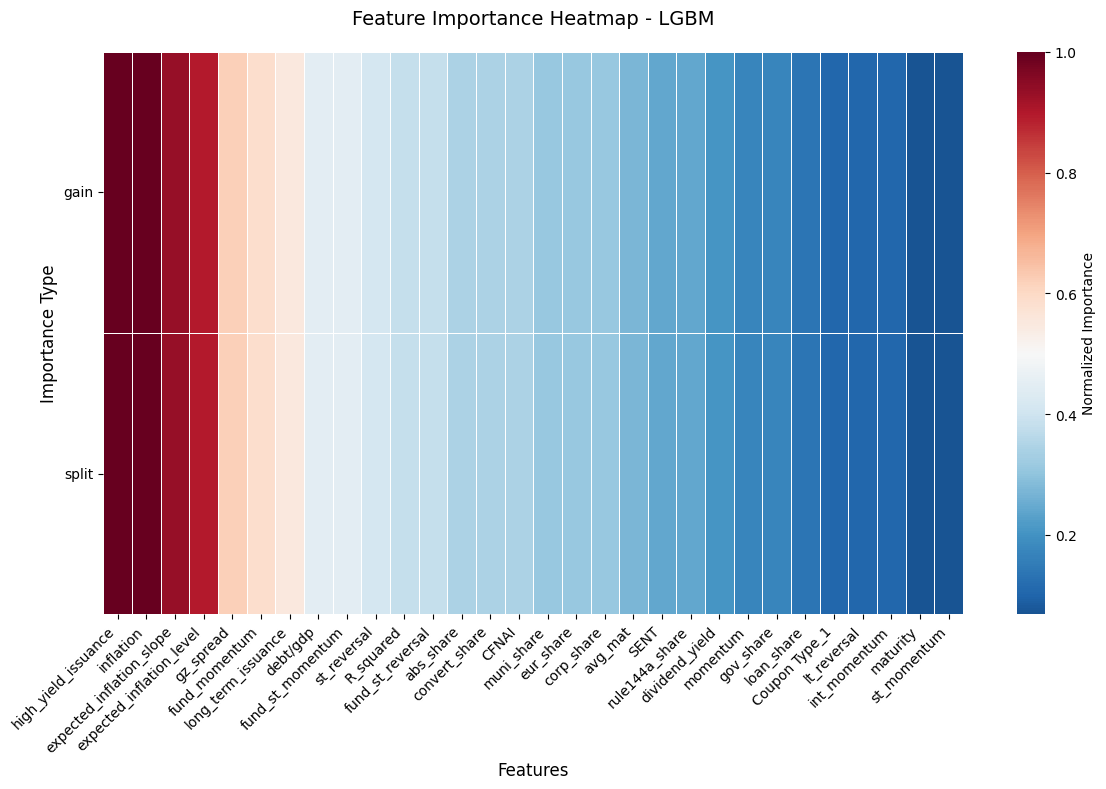

In [40]:
feature_names = XYpair[0][0].columns.tolist()

# Plot feature importance heatmap
importance_df = plot_lgbm_feature_importance_map(
    model=model,
    feature_names=feature_names,
    name="fundchar",
    model_name="LGBM",
    top_n=30
)

Top 9 most important features:
1. expected_inflation_level: 2.6246
2. inflation: 2.1730
3. st_reversal: 1.6864
4. expected_inflation_slope: 1.3514
5. high_yield_issuance: 1.2998
6. fund_st_reversal: 1.2897
7. gz_spread: 1.2746
8. fund_momentum: 1.1537
9. long_term_issuance: 0.8188

Among top features:
Continuous: ['expected_inflation_level', 'inflation', 'st_reversal', 'expected_inflation_slope', 'high_yield_issuance', 'fund_st_reversal', 'gz_spread', 'fund_momentum', 'long_term_issuance']
Categorical: []


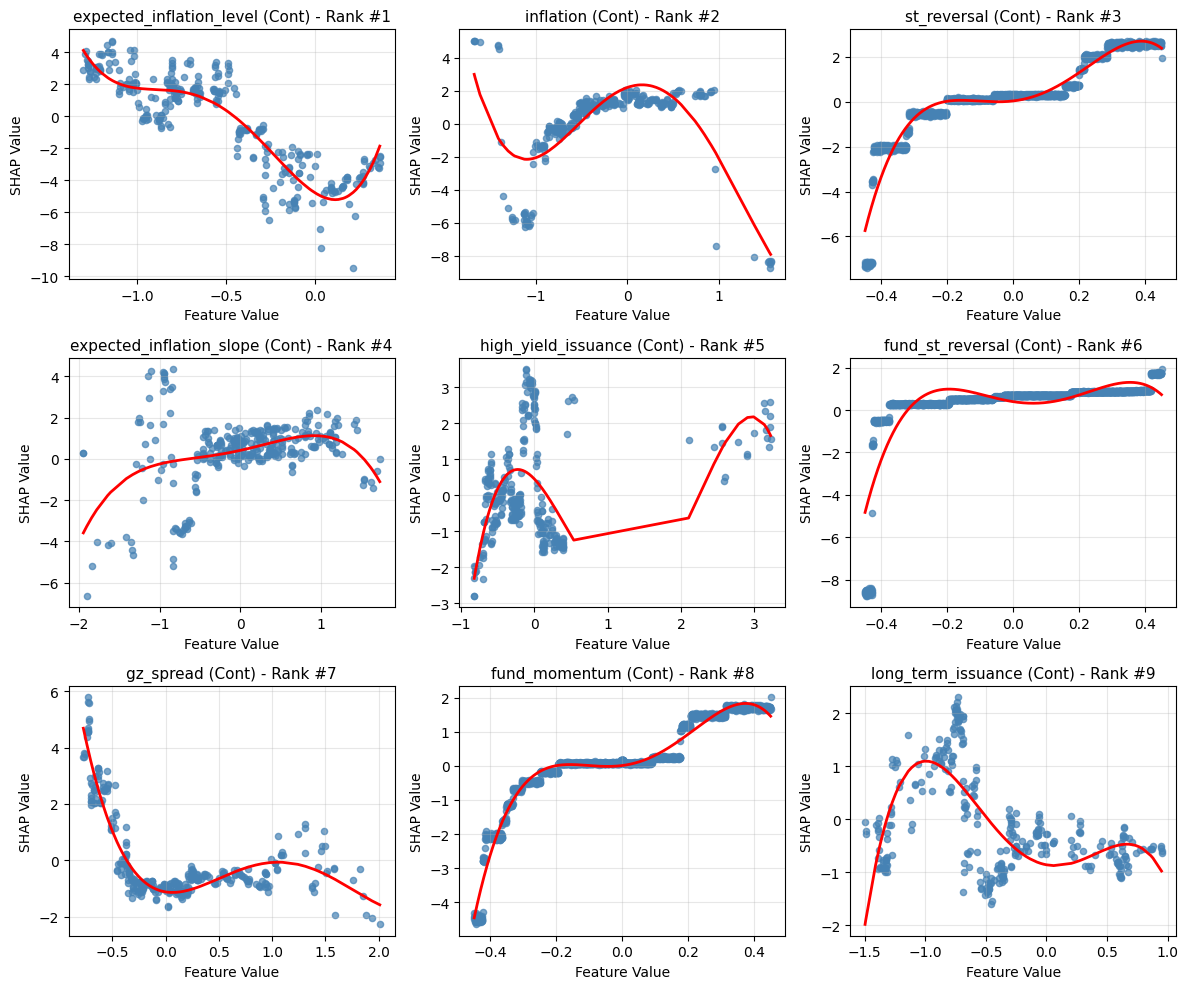

In [39]:
#plot top feature dependence (shap vs. feature)
cont_vars, cat_vars = plot_shap_top_features(shap_values, X_test, cat_cols)